In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import cv2
import tkinter 
from tkinter import messagebox
from tkinter import filedialog
from scipy import ndimage
import matplotlib.pyplot as plt
import math
import FRETBOARD
import pywt
from scipy.signal import find_peaks
from skimage.draw import polygon2mask
from skimage.morphology import skeletonize
from skimage import data
from skimage.util import invert
from skimage import transform as tf
from sklearn.cluster import KMeans
from sklearn import linear_model

In [2]:
# Chargement des images sous une liste
guitar_images = FRETBOARD.load_images_from_folder(f_n = 'frame')

In [3]:
# Load HED model
files = FRETBOARD.load_model_v2()
class CropLayer(object):
	    def __init__(self, params, blobs):
		    # initialize our starting and ending (x, y)-coordinates of
		    # the crop
		    self.startX = 0
		    self.startY = 0
		    self.endX = 0
		    self.endY = 0

	    def getMemoryShapes(self, inputs):
		    # the crop layer will receive two inputs -- we need to crop
		    # the first input blob to match the shape of the second one,
		    # keeping the batch size and number of channels
		    (inputShape, targetShape) = (inputs[0], inputs[1])
		    (batchSize, numChannels) = (inputShape[0], inputShape[1])
		    (H, W) = (targetShape[2], targetShape[3])

		    # compute the starting and ending crop coordinates
		    self.startX = int((inputShape[3] - targetShape[3]) / 2)
		    self.startY = int((inputShape[2] - targetShape[2]) / 2)
		    self.endX = self.startX + W
		    self.endY = self.startY + H

		    # return the shape of the volume (we'll perform the actual
		    # crop during the forward pass
		    return [[batchSize, numChannels, H, W]]

	    def forward(self, inputs):
		    # use the derived (x, y)-coordinates to perform the crop
		    return [inputs[0][:, :, self.startY:self.endY,
				    self.startX:self.endX]]  
protoPath = files[0]
modelPath = files[1]
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
cv2.dnn_registerLayer("Crop", CropLayer)

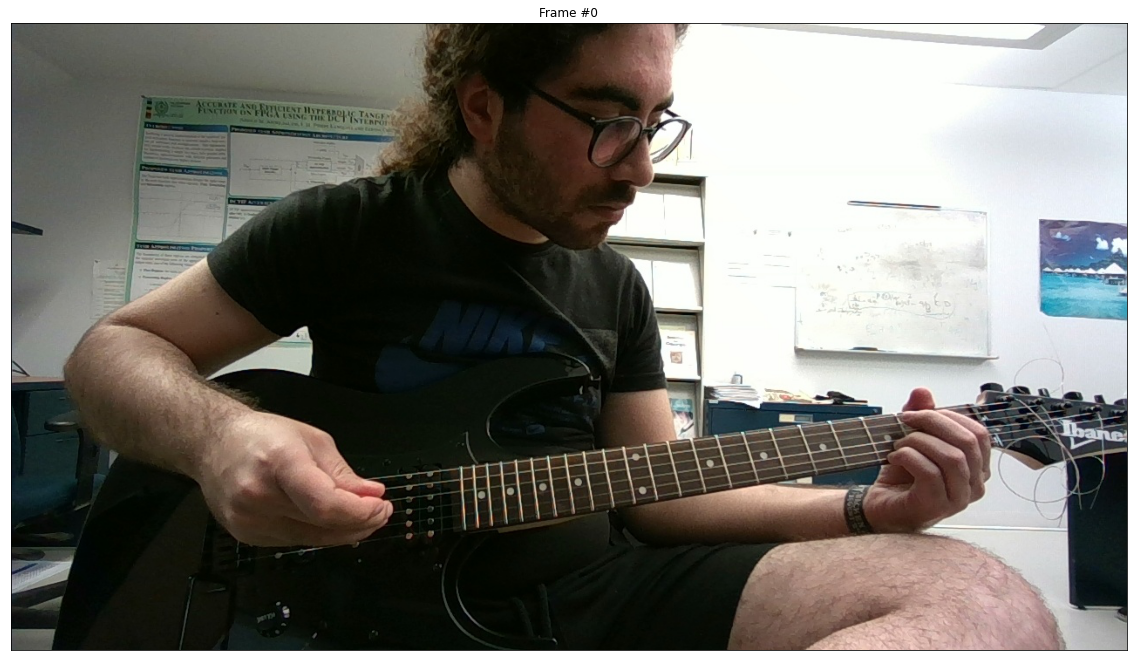

In [4]:
# Choix de l'image pour tester
n = 0
img_guitar_test = guitar_images[n]

fig = plt.figure(figsize=(20, 20))
plt.imshow(img_guitar_test)
plt.title(f"Frame #{str(n)}"), plt.xticks([]), plt.yticks([])
plt.show()

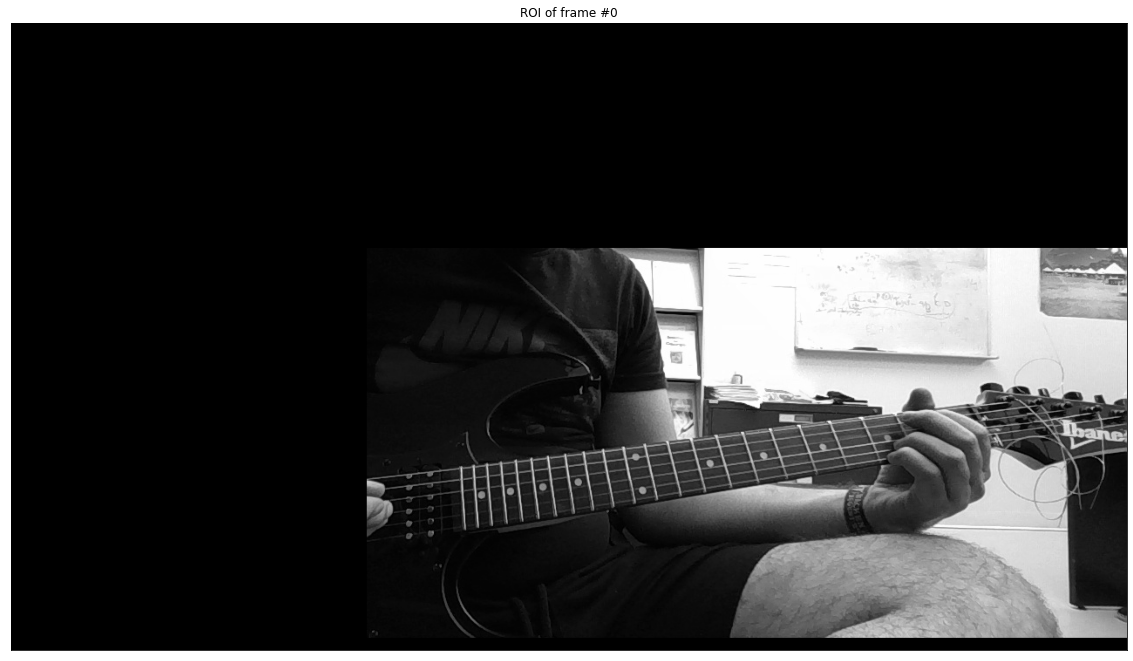

In [5]:
# Selection of ROI with Open cv
r, imCrop = FRETBOARD.select_ROI(guitar_images[n])

img_ncrop = cv2.cvtColor(guitar_images[n],cv2.COLOR_BGR2GRAY)
rows,columns = img_ncrop.shape

mask_nc = np.zeros([rows,columns])
mask_nc[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]=1

img_crop_whole = img_ncrop*mask_nc
fig = plt.figure(figsize=(20, 20))
plt.imshow(img_crop_whole,"gray")
plt.title(f"ROI of frame #{str(n)}"), plt.xticks([]), plt.yticks([])
plt.show()

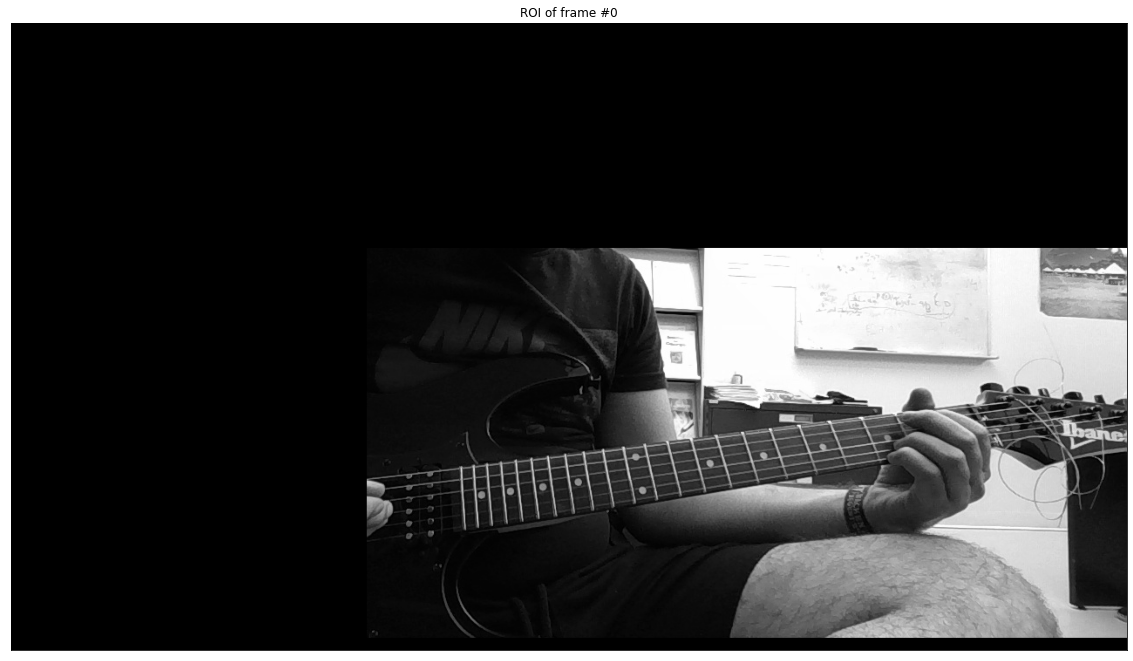

In [6]:
ImCrop = guitar_images[n][int(r[1]):int(r[1] + r[3]), int(r[0]):int(r[0] + r[2])]

img_ncrop = cv2.cvtColor(guitar_images[n],cv2.COLOR_BGR2GRAY)
rows,columns = img_ncrop.shape

mask_nc = np.zeros([rows,columns])
mask_nc[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]=1

img_crop_whole = img_ncrop*mask_nc
fig = plt.figure(figsize=(20, 20))
plt.imshow(img_crop_whole,"gray")
plt.title(f"ROI of frame #{str(n)}"), plt.xticks([]), plt.yticks([])
plt.show()

[INFO] getting image shape H,W: [447, 872]
[INFO] performing holistically-nested edge detection...


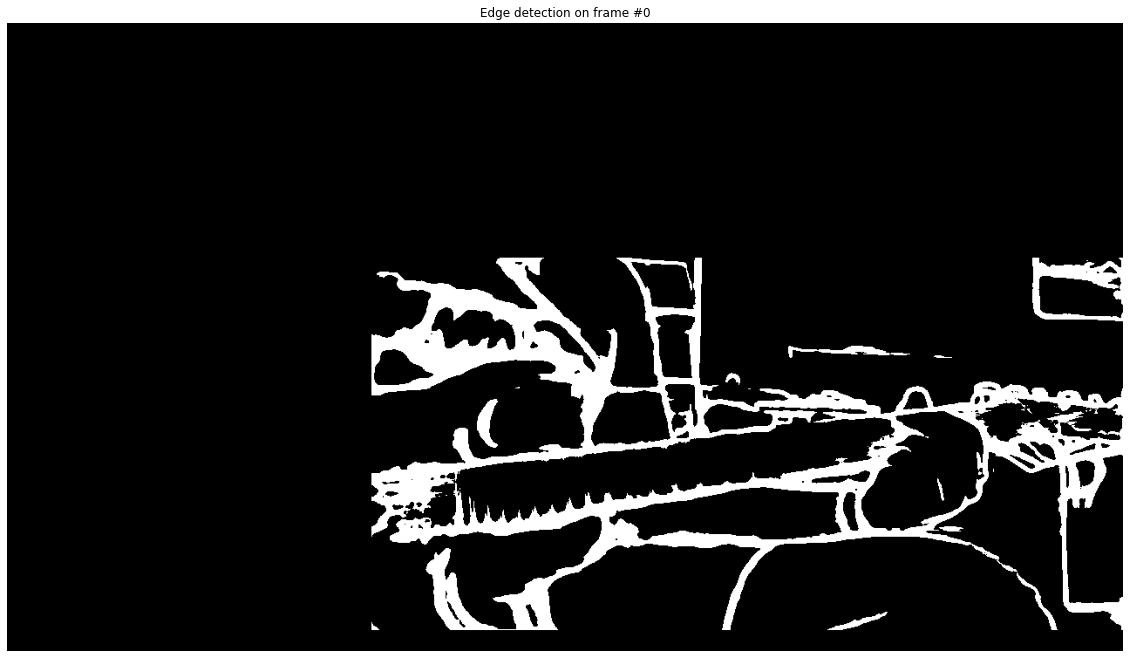

In [7]:
# HED manual
(H, W) = imCrop.shape[:2]
print("[INFO] getting image shape H,W:", [H,W])

blob = cv2.dnn.blobFromImage(imCrop, scalefactor=1.0, size=(W, H),
	swapRB=False, crop=False)

print("[INFO] performing holistically-nested edge detection...")
net.setInput(blob)
hed = net.forward()
hed = cv2.resize(hed[0, 0], (W, H))
hed = (255 * hed).astype("uint8")
hed = cv2.threshold(hed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] 

HED_whole = np.zeros(img_ncrop.shape)
HED_whole[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])] = hed
mask_b = mask_nc
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
mask_b = cv2.erode(mask_b, kernel, iterations=5)
HED_whole = HED_whole*mask_b

fig = plt.figure(figsize=(20, 20))
plt.imshow(HED_whole,"gray")
plt.title(f"Edge detection on frame #{str(n)}"), plt.xticks([]), plt.yticks([])
plt.axis("off")
plt.show()

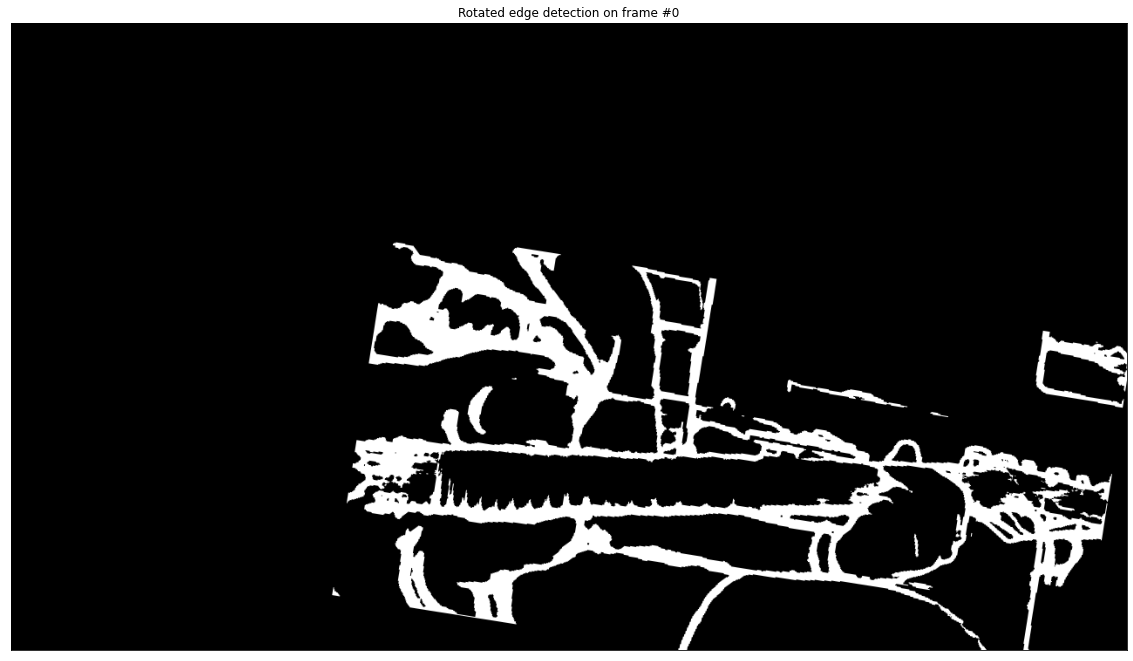

In [8]:
# Rotate image
linesP = FRETBOARD.Hough_linesP(hed,600)
angle = FRETBOARD.find_guitar_angle(linesP)
rot_HED = FRETBOARD.rotate_image(HED_whole,angle)

fig = plt.figure(figsize=(20, 20))
plt.imshow(rot_HED,"gray")
plt.title(f"Rotated edge detection on frame #{str(n)}"), plt.xticks([]), plt.yticks([])
plt.show()

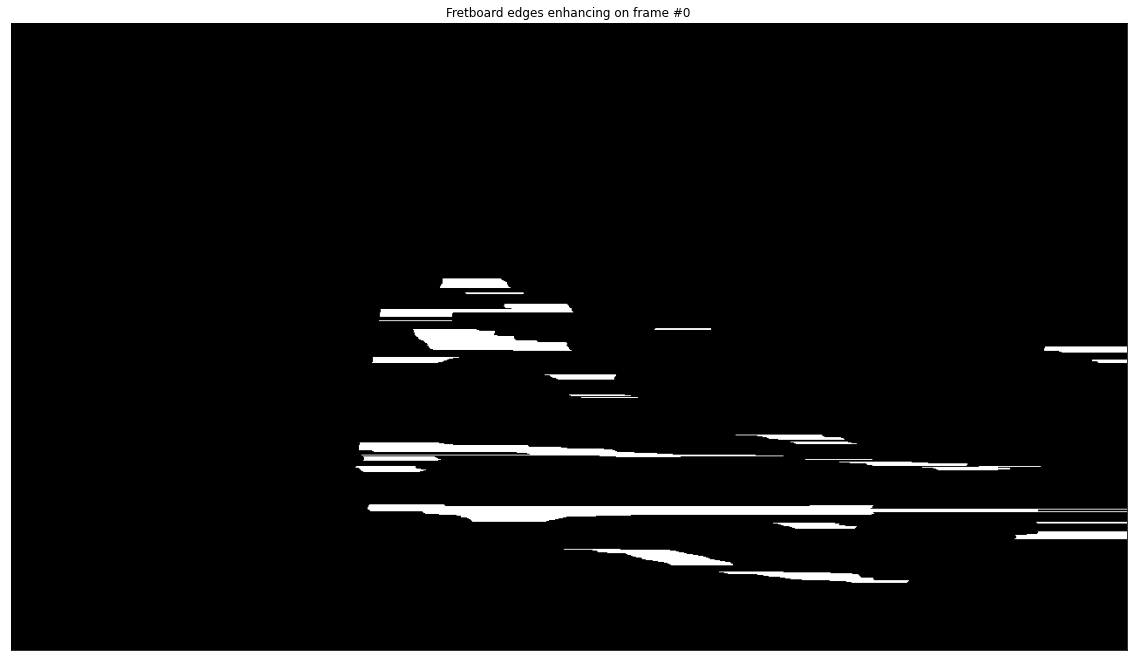

In [9]:
# Enhance the edges of fretboard
strings = FRETBOARD.strings_extraction(rot_HED,kernel_lenght = 20, niterations=1)
strings = cv2.threshold(np.uint8(strings), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] 

fig = plt.figure(figsize=(20, 20))
plt.imshow(strings,"gray")
plt.title(f"Fretboard edges enhancing on frame #{str(n)}"), plt.xticks([]), plt.yticks([])
plt.show()

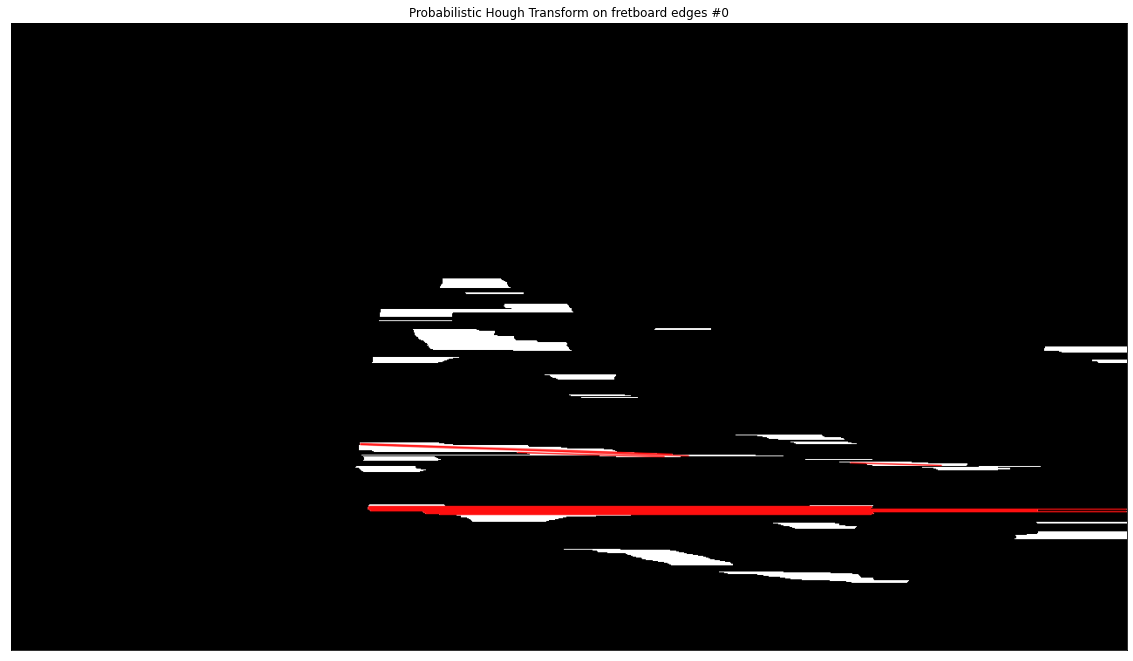

In [10]:
lin = 400
linesP = FRETBOARD.Hough_linesP(strings,lin)
# Probabilistic Hough Transform with Open cv with Open cv Canny on crop image
cdst = cv2.cvtColor(strings, cv2.COLOR_GRAY2BGR)     
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv2.LINE_AA)


fig = plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(cdst, cv2.COLOR_BGR2RGB))
plt.title(f"Probabilistic Hough Transform on fretboard edges #{str(n)}"), plt.xticks([]), plt.yticks([])
plt.show()

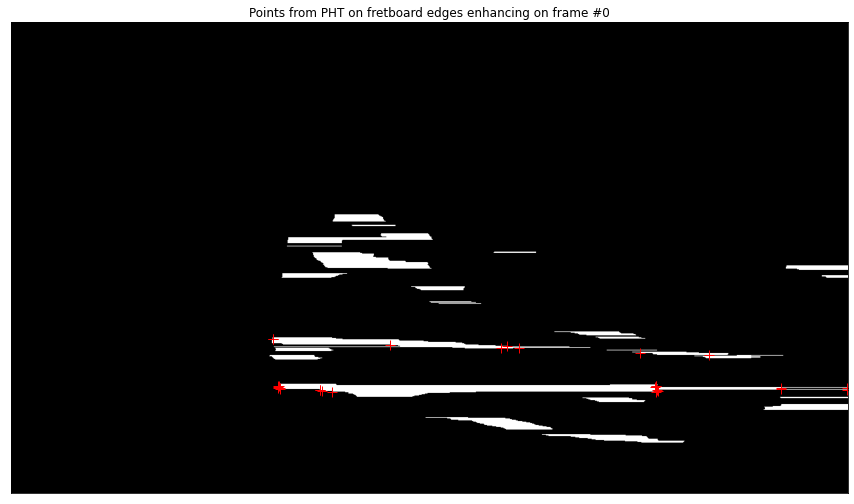

In [11]:
# Extract de points obtained from the probabilistic hough transform

pts = np.zeros((len(linesP),4))
for i in range(len(linesP)):
    pts[i] = linesP[i][0]
pts = pts.reshape(2*len(linesP),2)

fig, ax = plt.subplots()
ax.imshow(strings, cmap=plt.cm.gray)
ax.plot(pts[:, 0], pts[:, 1], '+r', markersize=10)
ax.set_title(f"Points from PHT on fretboard edges enhancing on frame #{str(n)}"), plt.xticks([]), plt.yticks([])
fig.set_size_inches(15,15)
plt.show()

C:\Users\rena_\anaconda3\envs\Projet-Guitare\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\rena_\anaconda3\envs\Projet-Guitare\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


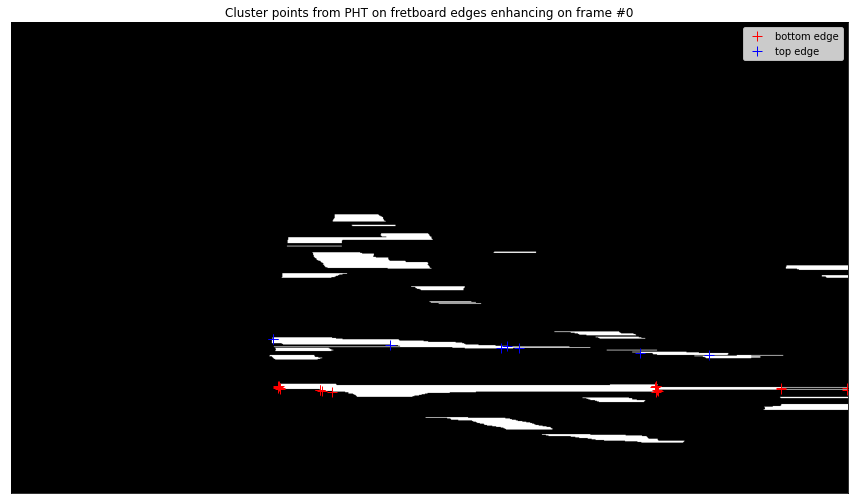

In [12]:
maxi = np.max(pts[:,1])
mini = np.min(pts[:,1])
moy = (maxi + mini)/2
pts_1 = []
pts_2 = []

for i in range(len(pts)):
    #if (pts[i,1] >= maxi*0.9 and pts[i,1] <= maxi*1.1):
    if pts[i,1] >= moy:
        pts_1.append(pts[i])
    else:
        pts_2.append(pts[i])

pts_1 = np.array(pts_1)
pts_2 = np.array(pts_2)

fig, ax = plt.subplots()
ax.imshow(strings, cmap=plt.cm.gray)
ax.plot(pts_1[:, 0], pts_1[:, 1], '+r', markersize=10, Label = 'bottom edge')
ax.plot(pts_2[:, 0], pts_2[:, 1], '+b', markersize=10, Label = 'top edge')
ax.legend()
ax.set_title(f"Cluster points from PHT on fretboard edges enhancing on frame #{str(n)}"), ax.set_xticks([]), ax.set_yticks([])
fig.set_size_inches(15,15)
plt.show()

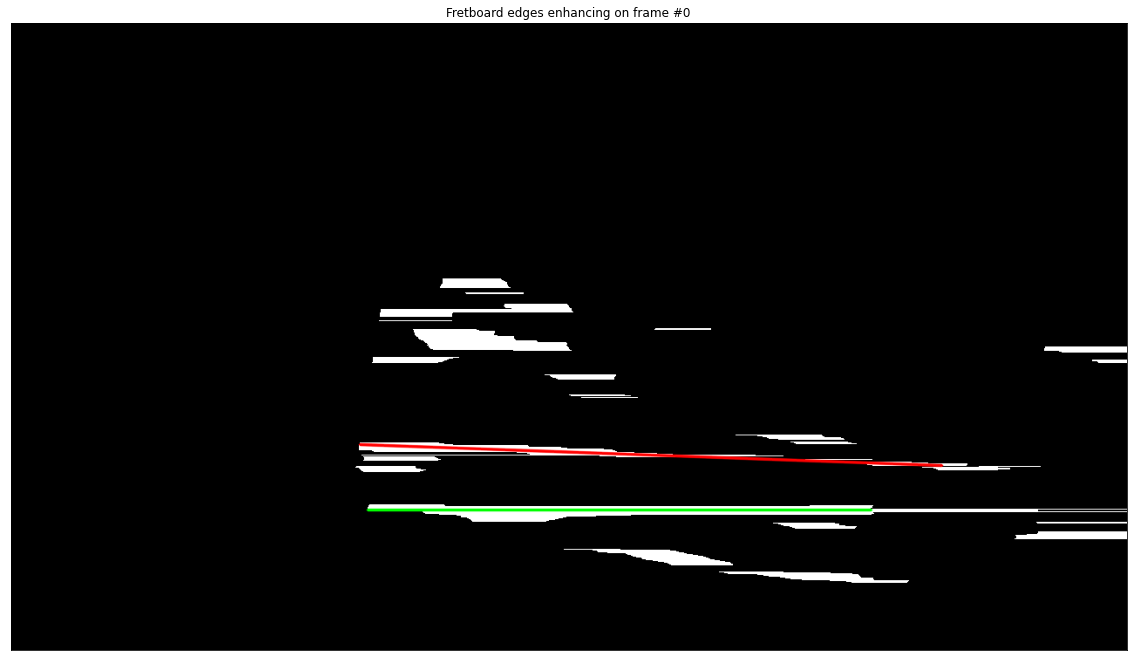

In [13]:
x = np.zeros([len(pts_2),1])
y = pts_2[:,1]

for i in range(len(pts_2)):
    x[i] = pts_2[i,0]

x1 = np.zeros([len(pts_1),1])
y1 = pts_1[:,1]

for j in range(len(pts_1)):
    x1[j] = pts_1[j,0]

# Create linear regression object
regr = linear_model.LinearRegression()
regr1 = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x, y)
regr1.fit(x1,y1)

# Make predictions using the testing set
y_pred = regr.predict(x)
y1_pred = regr1.predict(x1)

l = np.uint16(np.array([x[0][0], y_pred[0], x[-1][0], y_pred[-1]]))
l1 = np.uint16(np.array([x1[0][0], y1_pred[0], x1[-1][0], y1_pred[-1]]))

cdst = cv2.cvtColor(strings, cv2.COLOR_GRAY2BGR)  
cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,0,255), 2, cv2.LINE_AA)

cv2.line(cdst, (l1[0], l1[1]), (l1[2], l1[3]), (0,255,0), 2, cv2.LINE_AA)

fig = plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(cdst, cv2.COLOR_BGR2RGB))
plt.title(f"Fretboard edges enhancing on frame #{str(n)}"), plt.xticks([]), plt.yticks([])
plt.show()

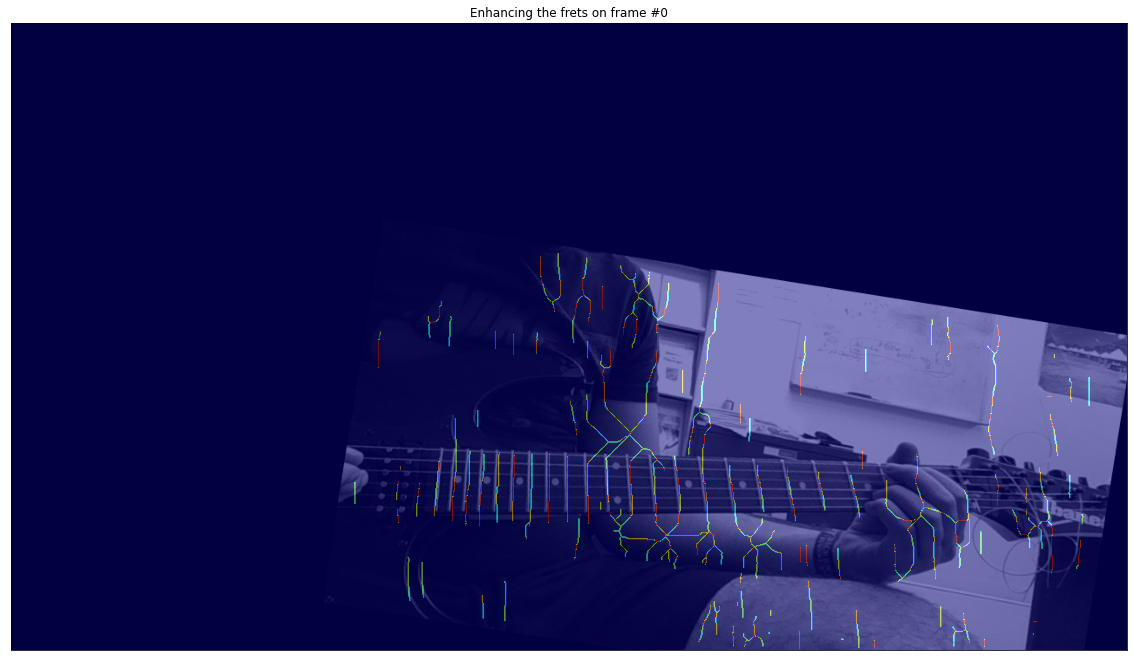

In [14]:
# Wavelet transform
rot_mask = FRETBOARD.rotate_image(mask_nc,angle)
rot_mask_b = rot_mask
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
rot_mask = cv2.erode(rot_mask, kernel, iterations=5)
rot_img = FRETBOARD.rotate_image(img_crop_whole,angle)
output_HL2 = FRETBOARD.wavelet_transform(rot_img)
output_HL2 = cv2.threshold(np.uint8(output_HL2*rot_mask), np.min(output_HL2), np.max(output_HL2), cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] 
out_frets = FRETBOARD.frets_extraction(output_HL2, kernel_lenght = 80, niterations=1)


fig = plt.figure(figsize=(20, 20))
plt.imshow(rot_img,cmap = 'gray')
plt.imshow(out_frets>0,cmap = 'jet',alpha=0.5)
plt.title(f"Enhancing the frets on frame #{str(n)}"), plt.xticks([]), plt.yticks([])
plt.show()

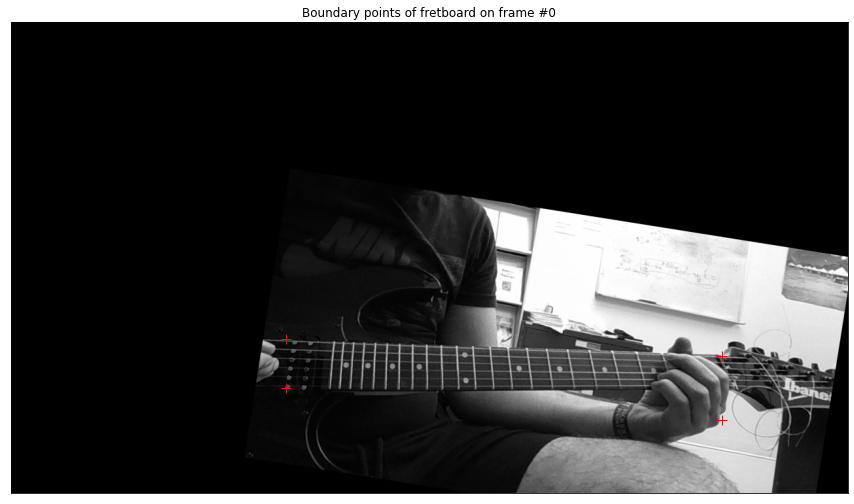

In [19]:
# Get 4 pts of bounding polygon
peaks_vert = FRETBOARD.vertical_proj_peaks_v2(out_frets,alpha=0.2)
pts = FRETBOARD.mask_pts_v2(strings,peaks_vert,threshold=400,vmin=1,vmax=-10)

fig, ax = plt.subplots()
ax.imshow(rot_img, cmap=plt.cm.gray)
ax.plot(pts[:, 0], pts[:, 1], '+r', markersize=10)
ax.set_title(f"Boundary points of fretboard on frame #{str(n)}"), ax.set_xticks([]), ax.set_yticks([])
fig.set_size_inches(15,15)
plt.show()

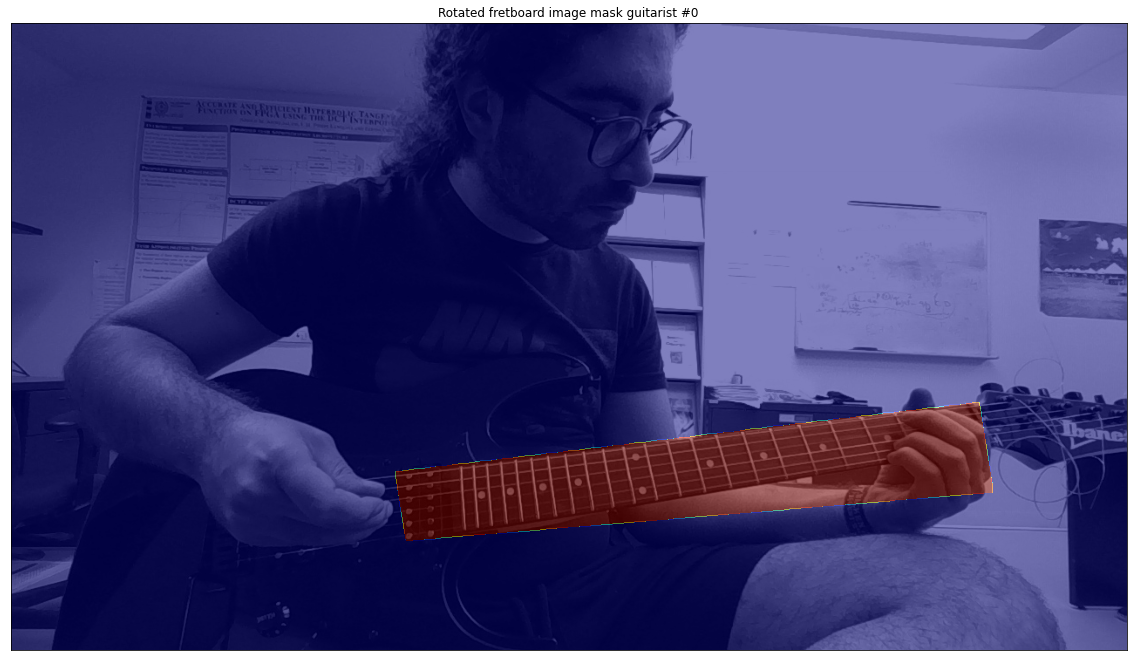

In [20]:
# Fretboard extraction
mask = FRETBOARD.fretboard_mask(img_crop_whole,pts,angle)
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(4,4))

mask_dilate = cv2.dilate(mask, dilate_kernel, iterations=2)
fig = plt.figure(figsize=(20, 20))
plt.imshow(img_ncrop,cmap = 'gray')
plt.imshow(mask_dilate,cmap = 'jet',alpha=0.5)
plt.title(f'Rotated fretboard image mask guitarist #{str(n)}'), plt.xticks([]), plt.yticks([])
plt.show()

In [24]:
while True:
    option = str(input('Keep current segmentation of fretboards?' + ' (y/n): ')).lower().strip()
    if option[0] == 'n':
        n = int(input("Please enter the number of the frame to correct the semgentation: "))
        mask = FRETBOARD.fretbord_correction(guitar_images[n])
    else:
       break

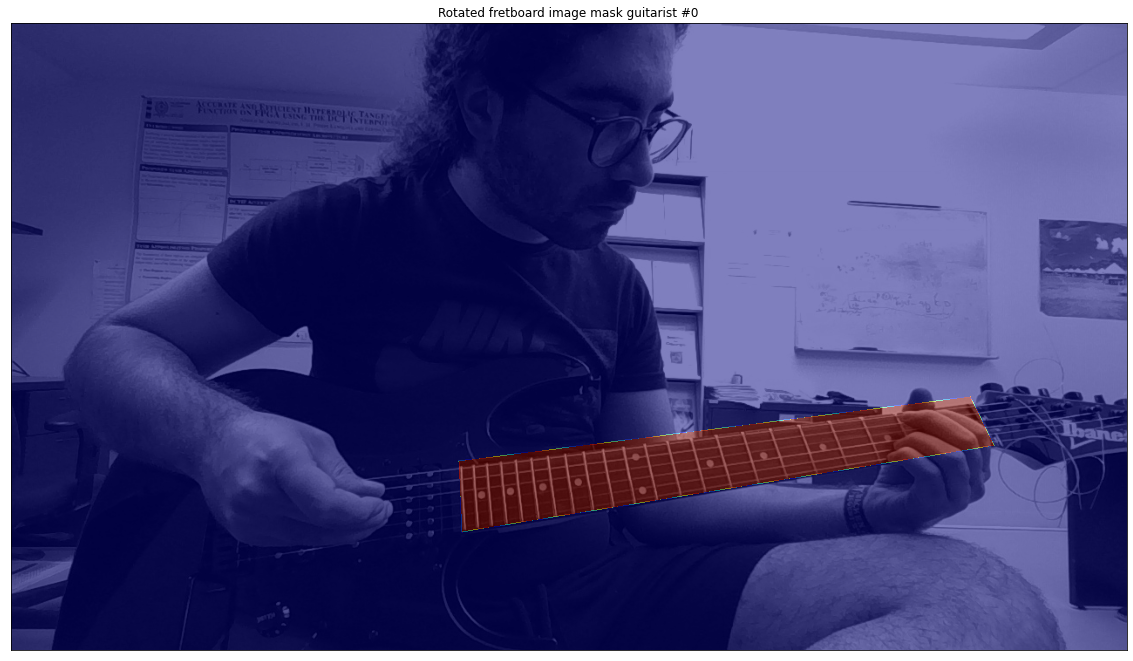

In [25]:
fig = plt.figure(figsize=(20, 20))
plt.imshow(img_ncrop,cmap = 'gray')
plt.imshow(mask,cmap = 'jet',alpha=0.5)
plt.title(f'Rotated fretboard image mask guitarist #{str(n)}'), plt.xticks([]), plt.yticks([])
plt.show()